<img src="https://developer-blogs.nvidia.com/wp-content/uploads/2020/09/dask-cloud.png" width="400" height = "50" >


## Group Project Descriptive & Predictive Analytics
## DSC Case Study

### Information on the work:

This work was done by Arunkkumar Karthikeyan, Ashval Vaidya and Zhibo Zhang.

#### Steps to be followed
     1.Project definition
     2.Data preparation
     3.Model Building
     4.Model Validation
     5.Model Usage

### 1. Project Definition

In this casestudy, we're asked to develop a model for an organization that helps non-profit organizations to find donors. This model will be used to predict whether a donor will be going to donate, given that this donor receives a re-activation campaign. The model will be trained based on the previous campaign data (campaign 6169), and then validated with another set of data from other campaign (campaign 7244).

The predictive model is expected to have a good performance and high interpretability. In addition, the results has to emphasize that why does implementing the predictive model is better than random guessing campaign (sending the reactivation campaign mails to randomly selected donor's). In the end, the model will be used to predict potential customers for the upcoming campaign, and which customers are the most effective to reach.

Thanks in advance for the time you will spend on our work. Yours faithfully, Team.

### 2. Data Preparation

#### 2.1 Importing external Libraries

In [407]:
# Data analysis and wrangling
import pandas as pd
import numpy as np
import datetime as dt
import sys

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Machine learning
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import RandomForestClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import AdaBoostClassifier
from sklearn.naive_bayes    import GaussianNB
from sklearn.neural_network import MLPClassifier
from scipy.stats.stats      import pearsonr
from sklearn.metrics        import accuracy_score, confusion_matrix
from sklearn.metrics        import classification_report
from sklearn.metrics        import accuracy_score
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score,roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [408]:
pd.options.mode.chained_assignment = None
import warnings 
warnings.filterwarnings(action= 'ignore')

#### 2.2 Local Path

In [409]:
sys.path.append(r"ieseg.py")

#### 2.3 Importing Local Libraries

In [410]:
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains

#### 2.4 Paths

In [411]:
# Defining Paths
directory = r"Predictive Modeling for DSC Fundraising Campaign"
inputData = directory + "/Raw Data"
sandbox   = directory + "/Sandbox"

#### 2.5 Importing the databases: 

In [412]:
# Importing the datasets

donor = pd.read_csv(inputData + "/donors.csv")
gifts = pd.read_csv(inputData + "/gifts.csv")
campaigns = pd.read_csv(inputData + "/campaigns.csv", sep=';')

donor_6169 = pd.read_csv(inputData + "/selection campaign 6169.csv")
donor_7244 = pd.read_csv(inputData + "/selection campaign 7244.csv")
donor_scoring = pd.read_csv(inputData + "/selection campaign 7662.csv")

In [413]:
# Global Values

campaignid_train = 6169
campaignid_test = 7244

#### --------------------------------------------------------------------------------------2.6 Donor's Dataset---------------------------------------------------------------------------------------------

In [414]:
# Analyzing the raw Donor's data
donor.head()

,Unnamed: 0,donorID,zipcode,province,region,gender,language,dateOfBirth
0,0,100001,1861.0,Flemish Brabant,Flanders,F,NL,12/24/1967
1,1,100002,2260.0,Antwerp,Flanders,M,NL,01/14/1952
2,2,100003,1780.0,Flemish Brabant,Flanders,M,NL,12/23/1986
3,3,100004,1020.0,Brussels,Brussels,F,FR,03/29/1952
4,4,100005,1020.0,Brussels,Brussels,F,FR,06/25/1986


In [415]:
# Checking the data size
donor.shape

(44691, 8)

In [416]:
# Checking for null values in the donor's data
donor.isna().sum().sum()

34

In [417]:
# Checking for null values in the donor's data
donor.isna().sum()

Unnamed: 0      0
donorID         0
zipcode         2
province        0
region          0
gender         32
language        0
dateOfBirth     0
dtype: int64

In [418]:
# Number of unique observations in donor's data
donor.nunique()

Unnamed: 0     44691
donorID        44691
zipcode         1024
province          13
region             4
gender             2
language           3
dateOfBirth    18406
dtype: int64

In [419]:
# Finding out the maximum value in DateofBirth variable in donor's data
donor['dateOfBirth'].max()

'12/31/1994'

In [420]:
# Finding out the information on donor's data
donor.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44691 entries, 0 to 44690
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   44691 non-null  int64  
 1   donorID      44691 non-null  int64  
 2   zipcode      44689 non-null  float64
 3   province     44691 non-null  object 
 4   region       44691 non-null  object 
 5   gender       44659 non-null  object 
 6   language     44691 non-null  object 
 7   dateOfBirth  44691 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.7+ MB


In [421]:
# Changing dateOfBirth column to date format

donor['dateOfBirth'] = pd.to_datetime(donor['dateOfBirth'])
donor.head()

,Unnamed: 0,donorID,zipcode,province,region,gender,language,dateOfBirth
0,0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24
1,1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14
2,2,100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23
3,3,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29
4,4,100005,1020.0,Brussels,Brussels,F,FR,1986-06-25


In [422]:
# Missing Region and Province in the donor dataset
donor['region'].unique()

array(['Flanders', 'Brussels', 'Wallonia', 'Missing'], dtype=object)

In [423]:
# We understood that for the above missing values the language is EN and all donors whose langauge is English the region of the donor
# is Flanders and province is Flemish Brabant and hence we have filled the missing cells with these values
donor["province"] = np.where((donor["province"] == "Missing"), 'Flemish Brabant', donor["province"])
donor["region"] = np.where((donor["region"] == "Missing"), 'Flanders', donor["region"])
donor.head()

,Unnamed: 0,donorID,zipcode,province,region,gender,language,dateOfBirth
0,0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24
1,1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14
2,2,100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23
3,3,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29
4,4,100005,1020.0,Brussels,Brussels,F,FR,1986-06-25


In [424]:
donor['region'].unique()

array(['Flanders', 'Brussels', 'Wallonia'], dtype=object)

In [425]:
donor['language'].unique()

array(['NL', 'FR', 'EN'], dtype=object)

In [426]:
# Finding out the missing zipcode donor 

donor_filter = donor.loc[(donor["language"] == 'EN') & (donor["province"] == "Flemish Brabant") & (donor["region"] == 'Flanders')]
donor_zpcd = donor_filter.groupby(['province','region','language'])['zipcode'].value_counts().rename('count').reset_index()
donor_zpcd.head()

,province,region,language,zipcode,count
0,Flemish Brabant,Flanders,EN,3080.0,3
1,Flemish Brabant,Flanders,EN,3090.0,1


In [427]:
# Finding out the proportion of gender per region
# https://stackoverflow.com/questions/61184992/find-percentage-of-male-and-female

prop_gender_region = donor.groupby('region')['gender'].value_counts(normalize=True).reset_index(name='perc')
prop_gender_region.head()

,region,gender,perc
0,Brussels,M,0.580754
1,Brussels,F,0.419246
2,Flanders,M,0.579250
3,Flanders,F,0.420750
4,Wallonia,M,0.553003


In [428]:
# Since the proportion of males are higher than females in all regions, the missing values in gender variable has been replaced 
# by Male
# Replace Null values in gender with "Male"

donor['gender'] = np.where(donor['gender'].isna(),'M',donor['gender'])

In [429]:
# Checking for null values in the donor's data
donor.isna().sum()

Unnamed: 0     0
donorID        0
zipcode        2
province       0
region         0
gender         0
language       0
dateOfBirth    0
dtype: int64

In [430]:
# Replace Province with capital letters (ANTWERP) to other data's

donor.replace({'ANTWERP':'Antwerp'},inplace=True)

In [431]:
# Creating new aggregated variables 

no_of_donor_province = donor.groupby('province')['gender'].count().reset_index(name='no_of_donors_province')
no_of_donor_province.head()

,province,no_of_donors_province
0,Antwerp,10450
1,Brussels,1488
2,East Flanders,9137
3,Flemish Brabant,6783
4,Hainaut,944


In [432]:
# Creating new aggregated variables 

no_of_donor_region = donor.groupby('region')['gender'].count().reset_index(name='no_of_donors_region')
no_of_donor_region.head()

,region,no_of_donors_region
0,Brussels,1488
1,Flanders,40152
2,Wallonia,3051


In [433]:
# Finding out the regions where zipcodes are zero

zip_cd = donor.groupby(['region','zipcode','province']).size().rename('count').reset_index()
zip_cd[zip_cd['zipcode'] == 0]

,region,zipcode,province,count
541,Wallonia,0.0,Walloon Brabant,1


In [434]:
# Finding out the count of zipcodes in province Flemish Brabant

zip_fla = zip_cd[(zip_cd['region'] == 'Flanders') & (zip_cd['province'] == 'Flemish Brabant')]
zip_fla_count = zip_fla.sort_values('count',ascending=False)
zip_fla_count.head()

,region,zipcode,province,count
186,Flanders,3000.0,Flemish Brabant,284
187,Flanders,3001.0,Flemish Brabant,254
229,Flanders,3300.0,Flemish Brabant,217
188,Flanders,3010.0,Flemish Brabant,208
203,Flanders,3080.0,Flemish Brabant,173


In [435]:
# As we understood that the donors from zipcode 3000 is high in province Flemish Brabant so we have replaced the zipcode 0
# with 3000 for province Flemish Brabant

donor['zipcode'] = np.where((donor['zipcode'] == 0) & (donor['region'] == 'Flanders'),3000,donor['zipcode'])

In [436]:
# Finding out the count of zipcodes in province Flemish Brabant

zip_wal = zip_cd[(zip_cd['region'] == 'Wallonia') & (zip_cd['province'] == 'Walloon Brabant')]
zip_wal_count = zip_wal.sort_values('count',ascending=False)
zip_wal_count.head()

,region,zipcode,province,count
564,Wallonia,1410.0,Walloon Brabant,51
562,Wallonia,1400.0,Walloon Brabant,33
542,Wallonia,1300.0,Walloon Brabant,32
560,Wallonia,1380.0,Walloon Brabant,30
565,Wallonia,1420.0,Walloon Brabant,27


In [437]:
# As we understood that the donors from zipcode 1410 is high in province Flemish Walloon Brabant so we have replaced the zipcode 
# 0 with 1410 for province Flemish Brabant

donor['zipcode'] = np.where((donor['zipcode'] == 0) & (donor['region'] == 'Wallonia'),1410,donor['zipcode'])

In [438]:
# Replace the categorical gender column with 1 and 0 (into numerical) 
# Replace the language column with respective language names

donor.replace({'FR':'French',
               'NL':'Dutch',
               'EN':'English'
               },inplace=True)

In [439]:
# Copying donor file to donor_profile

donor_profile = donor.copy()

In [440]:
# Creating dummy variables (One-Hot encoding) and column name fixing
donor = pd.get_dummies(donor, columns=['gender','province', 'region', 'language'], drop_first=False)
donor.head()

,Unnamed: 0,donorID,zipcode,dateOfBirth,gender_F,gender_M,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,...,province_Luxembourg,province_Namur,province_Walloon Brabant,province_West Flanders,region_Brussels,region_Flanders,region_Wallonia,language_Dutch,language_English,language_French
0,0,100001,1861.0,1967-12-24,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,1,100002,2260.0,1952-01-14,0,1,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
2,2,100003,1780.0,1986-12-23,0,1,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
3,3,100004,1020.0,1952-03-29,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
4,4,100005,1020.0,1986-06-25,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1


In [441]:
# Dropping the unwanted columns
donor = donor.drop(['Unnamed: 0','zipcode'],axis=1)

#### --------------------------------------------------------------------------------------2.7 Campaign Dataset---------------------------------------------------------------------------------------------

In [442]:
# Analyzing the raw Donor's data
campaigns.head()

,campaignID,date,lettersSent,CostUnit
0,153,13/12/2004,6 873,"0,17 €"
1,154,01/01/2005,7 656,"0,30 €"
2,180,18/01/2005,9 933,"0,20 €"
3,433,29/01/2005,7 448,"0,59 €"
4,476,12/02/2005,6 605,"0,51 €"


In [443]:
# Checking the data size
campaigns.shape

(367, 4)

In [444]:
# Checking for null values in the donor's data
campaigns.isna().sum().sum()

0

In [445]:
campaigns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367 entries, 0 to 366
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   campaignID   367 non-null    int64 
 1   date         367 non-null    object
 2   lettersSent  367 non-null    object
 3   CostUnit     367 non-null    object
dtypes: int64(1), object(3)
memory usage: 11.6+ KB


In [446]:
campaigns['lettersSent'] = campaigns['lettersSent'].astype(str).str.replace('\u202f','').astype(int)
campaigns['CostUnit'] = campaigns['CostUnit'].astype(str).str.replace('\xa0€','').str.replace(',','.').astype(float)
campaigns['date'] = pd.to_datetime(campaigns['date'])
campaigns = campaigns.rename(columns={'date':'campaign_date'})
campaigns

,campaignID,campaign_date,lettersSent,CostUnit
0,153,2004-12-13,6873,0.17
1,154,2005-01-01,7656,0.30
2,180,2005-01-18,9933,0.20
3,433,2005-01-29,7448,0.59
4,476,2005-12-02,6605,0.51
...,...,...,...,...
362,7494,2019-10-17,8539,0.14
363,7503,2019-10-29,6126,0.15
364,7505,2019-11-16,29746,0.12
365,7519,2019-11-26,35199,0.36


#### --------------------------------------------------------------------------------------2.8 Gifts Dataset---------------------------------------------------------------------------------------------

In [447]:
# Analyzing the raw Donor's data
gifts.head()

,Unnamed: 0,donorID,campaignID,amount,date
0,0,100001,NaN,"12,39",2004-03-23
1,1,100001,1577.0,"12,39",2007-10-11
2,2,100001,1634.0,"6,69",2007-12-28
3,3,100001,1778.0,"24,79",2008-06-14
4,4,100001,1808.0,"7,44",2008-07-09


In [448]:
# Checking the data size
gifts.shape

(216594, 5)

In [449]:
gifts['amount'].max()

'991,57'

In [450]:
# Checking for null values in the gifts data
gifts.isna().sum().sum()

15637

In [451]:
# Checking for null values in the gifts data
gifts.isna().sum()

Unnamed: 0        0
donorID           0
campaignID    15637
amount            0
date              0
dtype: int64

In [452]:
# Number of unique observations in donor's data
gifts.nunique()

Unnamed: 0    216594
donorID        44700
campaignID       367
amount          1170
date            6113
dtype: int64

In [453]:
# Finding out the information on donor's data
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216594 entries, 0 to 216593
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  216594 non-null  int64  
 1   donorID     216594 non-null  int64  
 2   campaignID  200957 non-null  float64
 3   amount      216594 non-null  object 
 4   date        216594 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 8.3+ MB


In [454]:
# Creating a dummy variable for missing campaign ID (donations outside of campaigns)

gifts['campaignID_NA'] = 0
gifts.loc[gifts['campaignID'].isna(), 'campaignID_NA'] = 1

In [455]:
# Changing date column to date format

gifts['date'] = pd.to_datetime(gifts['date'])
gifts.head()

,Unnamed: 0,donorID,campaignID,amount,date,campaignID_NA
0,0,100001,NaN,"12,39",2004-03-23,1
1,1,100001,1577.0,"12,39",2007-10-11,0
2,2,100001,1634.0,"6,69",2007-12-28,0
3,3,100001,1778.0,"24,79",2008-06-14,0
4,4,100001,1808.0,"7,44",2008-07-09,0


In [456]:
# Replacing the informats in amount column 

gifts['amount'].head()
gifts['amount'] = gifts['amount'].str.replace(',', '.').astype(float)
gifts.head()

,Unnamed: 0,donorID,campaignID,amount,date,campaignID_NA
0,0,100001,NaN,12.39,2004-03-23,1
1,1,100001,1577.0,12.39,2007-10-11,0
2,2,100001,1634.0,6.69,2007-12-28,0
3,3,100001,1778.0,24.79,2008-06-14,0
4,4,100001,1808.0,7.44,2008-07-09,0


In [457]:
# Finding out the columns which has non-missing values (these observations / donors are those who have donated gifts in campaign)
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.notnull.html

gifts_out = gifts[gifts['campaignID'].notnull()]
gifts_out.head()

,Unnamed: 0,donorID,campaignID,amount,date,campaignID_NA
1,1,100001,1577.0,12.39,2007-10-11,0
2,2,100001,1634.0,6.69,2007-12-28,0
3,3,100001,1778.0,24.79,2008-06-14,0
4,4,100001,1808.0,7.44,2008-07-09,0
5,5,100001,1933.0,24.79,2008-12-01,0


In [458]:
# Filling missing values with 0 in Campaign ID

gifts['campaignID']= gifts['campaignID'].fillna(0)
gifts['campaignID'] = gifts['campaignID'].astype(int)

In [459]:
# Creating month variable from date in gifts

gifts['month'] = gifts['date'].dt.month

In [460]:
# Filtering for Train and test data (considered last 5 years of data for analysis)

gifts_train = gifts[(gifts['date'] > '2013-08-04') & (gifts['date'] <= '2018-08-04')]
gifts_test = gifts[(gifts['date'] > '2014-05-18') & (gifts['date'] <= '2019-05-18')]
gifts_new = gifts[(gifts['date'] > '2015-01-04') & (gifts['date'] <= '2020-01-04')]

In [461]:
# Maximum and Minimum gift donated by each donor for train, test and new dataset

gifts_train = pd.merge(gifts_train,gifts_train.groupby('donorID')['amount'].max().reset_index().rename(columns={'amount':'max_gift'}),on='donorID', how='left')
gifts_train = pd.merge(gifts_train,gifts_train.groupby('donorID')['amount'].min().reset_index().rename(columns={'amount':'min_gift'}),on='donorID', how='left')
gifts_test = pd.merge(gifts_test,gifts_test.groupby('donorID')['amount'].max().reset_index().rename(columns={'amount':'max_gift'}),on='donorID', how='left')
gifts_test = pd.merge(gifts_test,gifts_test.groupby('donorID')['amount'].min().reset_index().rename(columns={'amount':'min_gift'}),on='donorID', how='left')
gifts_new = pd.merge(gifts_new,gifts_new.groupby('donorID')['amount'].max().reset_index().rename(columns={'amount':'max_gift'}),on='donorID', how='left')
gifts_new = pd.merge(gifts_new,gifts_new.groupby('donorID')['amount'].min().reset_index().rename(columns={'amount':'min_gift'}),on='donorID', how='left')

In [462]:
# First and Last Donation made by each donor for train, test and new dataset

gifts_train = pd.merge(gifts_train,gifts_train.groupby('donorID')['date'].agg('max').reset_index().rename(columns={'date':'last_donation'}),on='donorID',how='left')
gifts_train = pd.merge(gifts_train,gifts_train.groupby('donorID')['date'].agg('min').reset_index().rename(columns={'date':'first_donation'}),on='donorID',how='left')
gifts_test = pd.merge(gifts_test,gifts_test.groupby('donorID')['date'].agg('max').reset_index().rename(columns={'date':'last_donation'}),on='donorID',how='left')
gifts_test = pd.merge(gifts_test,gifts_test.groupby('donorID')['date'].agg('min').reset_index().rename(columns={'date':'first_donation'}),on='donorID',how='left')
gifts_new = pd.merge(gifts_new,gifts_train.groupby('donorID')['date'].agg('max').reset_index().rename(columns={'date':'last_donation'}),on='donorID',how='left')
gifts_new = pd.merge(gifts_new,gifts_train.groupby('donorID')['date'].agg('min').reset_index().rename(columns={'date':'first_donation'}),on='donorID',how='left')

In [463]:
# Function to calculate monthly amount donation for train, test and new dataset

def mw(df):
    global gifts_month
    gifts_month = df.groupby(['donorID','month'])['amount'].agg(['sum'])
    gifts_month = pd.DataFrame(gifts_month)
    gifts_month = gifts_month.reset_index()
    gifts_month = pd.pivot_table(gifts_month,columns=['month'],index='donorID')    # Pivot the enitre table monthwise
    for col in gifts_month.columns:
        gifts_month = gifts_month.rename(columns={col[1]:col[0]+ '_' + str(col[1])})
    gifts_month = gifts_month['sum']
    df = pd.merge(df,gifts_month,how='left',on='donorID')
    df = df.drop_duplicates(subset='donorID')
    return df

# Calling the function
gifts_train = mw(gifts_train)
gifts_test = mw(gifts_test)
gifts_new = mw(gifts_new)

In [464]:
# Replacing the missing values in monthwise donation and other variables as zero in train data

gifts_train['last_donation']=pd.to_datetime(gifts_train['last_donation'], format='%Y/%m/%d')
gifts_train['first_donation']=pd.to_datetime(gifts_train['first_donation'], format='%Y/%m/%d')
gifts_train.loc[gifts_train.max_gift.isna(),'max_gift']=0
gifts_train.loc[gifts_train.min_gift.isna(),'min_gift']=0
gifts_train.loc[gifts_train.sum_1.isna(),'sum_1']=0
gifts_train.loc[gifts_train.sum_2.isna(),'sum_2']=0
gifts_train.loc[gifts_train.sum_3.isna(),'sum_3']=0
gifts_train.loc[gifts_train.sum_4.isna(),'sum_4']=0
gifts_train.loc[gifts_train.sum_5.isna(),'sum_5']=0
gifts_train.loc[gifts_train.sum_6.isna(),'sum_6']=0
gifts_train.loc[gifts_train.sum_7.isna(),'sum_7']=0
gifts_train.loc[gifts_train.sum_8.isna(),'sum_8']=0
gifts_train.loc[gifts_train.sum_9.isna(),'sum_9']=0
gifts_train.loc[gifts_train.sum_10.isna(),'sum_10']=0
gifts_train.loc[gifts_train.sum_11.isna(),'sum_11']=0
gifts_train.loc[gifts_train.sum_12.isna(),'sum_12']=0

In [465]:
# Replacing the missing values in monthwise donation and other variables as zero in test data

gifts_test['last_donation']=pd.to_datetime(gifts_test['last_donation'], format='%Y/%m/%d')
gifts_test['first_donation']=pd.to_datetime(gifts_test['first_donation'], format='%Y/%m/%d')
gifts_test.loc[gifts_test.max_gift.isna(),'max_gift']=0
gifts_test.loc[gifts_test.min_gift.isna(),'min_gift']=0
gifts_test.loc[gifts_test.sum_1.isna(),'sum_1']=0
gifts_test.loc[gifts_test.sum_2.isna(),'sum_2']=0
gifts_test.loc[gifts_test.sum_3.isna(),'sum_3']=0
gifts_test.loc[gifts_test.sum_4.isna(),'sum_4']=0
gifts_test.loc[gifts_test.sum_5.isna(),'sum_5']=0
gifts_test.loc[gifts_test.sum_6.isna(),'sum_6']=0
gifts_test.loc[gifts_test.sum_7.isna(),'sum_7']=0
gifts_test.loc[gifts_test.sum_8.isna(),'sum_8']=0
gifts_test.loc[gifts_test.sum_9.isna(),'sum_9']=0
gifts_test.loc[gifts_test.sum_10.isna(),'sum_10']=0
gifts_test.loc[gifts_test.sum_11.isna(),'sum_11']=0
gifts_test.loc[gifts_test.sum_12.isna(),'sum_12']=0


In [466]:
# Replacing the missing values in monthwise donation and other variables as zero in new data

gifts_new['last_donation']=pd.to_datetime(gifts_new['last_donation'], format='%Y/%m/%d')
gifts_new['first_donation']=pd.to_datetime(gifts_new['first_donation'], format='%Y/%m/%d')
gifts_new.loc[gifts_new.max_gift.isna(),'max_gift']=0
gifts_new.loc[gifts_new.min_gift.isna(),'min_gift']=0
gifts_new.loc[gifts_new.sum_1.isna(),'sum_1']=0
gifts_new.loc[gifts_new.sum_2.isna(),'sum_2']=0
gifts_new.loc[gifts_new.sum_3.isna(),'sum_3']=0
gifts_new.loc[gifts_new.sum_4.isna(),'sum_4']=0
gifts_new.loc[gifts_new.sum_5.isna(),'sum_5']=0
gifts_new.loc[gifts_new.sum_6.isna(),'sum_6']=0
gifts_new.loc[gifts_new.sum_7.isna(),'sum_7']=0
gifts_new.loc[gifts_new.sum_8.isna(),'sum_8']=0
gifts_new.loc[gifts_new.sum_9.isna(),'sum_9']=0
gifts_new.loc[gifts_new.sum_10.isna(),'sum_10']=0
gifts_new.loc[gifts_new.sum_11.isna(),'sum_11']=0
gifts_new.loc[gifts_new.sum_12.isna(),'sum_12']=0

In [467]:
# Defining a class function for RFM Analysis of gifts

class Gifts_RFM(object):
    def __init__(self,df,date):
        # Initiate class variables
        self.df = df
        self.date = pd.to_datetime(date, format='%Y-%m-%d')
    
    def Frequency(self):  #Frequency Analysis (How often do the donor donated the gifts in selected timeframe?)
        global gifts_campaigns
        gifts_campaigns =  self.df.groupby('donorID')['campaignID'].agg('count')
        gifts_campaigns = gifts_campaigns.reset_index()
        gifts_campaigns = gifts_campaigns.rename(columns={'campaignID':'No_campaigns'})
        return gifts_campaigns

    def monetary(self):   #Calculate variables from amount #Monetary Analysis (How much does the donor donated in the selected time frame?)
        global gifts_amount
        gifts_amount = self.df.groupby('donorID')['amount'].agg(['sum','mean','max','min'])
        gifts_amount = gifts_amount.reset_index()
        gifts_amount = gifts_amount.rename(columns={'sum':'Tot_Amt','mean':'Avg_Amt','max':'Max_Amt','min':'Min_Amt'})
        return gifts_amount
    
    def recency(self):    #recency - Recency Analysis for the selected timeframe (How recently did the customer has donated the gifts?)
        global gifts_recency
        gifts_recency = self.df[['donorID']]
        gifts_recency['recency'] = self.date - self.df['last_donation']
        gifts_recency['recency'] = gifts_recency['recency'].astype(str).str[:-5].astype(int)
        return gifts_recency

    def merge(self):     #Merging the variables into final basetable
        gifts_rfm = pd.merge(self.df,gifts_campaigns,how='left',on='donorID')
        gifts_rfm = pd.merge(gifts_rfm,gifts_amount,how='left',on='donorID')
        gifts_rfm = pd.merge(gifts_rfm,gifts_recency,how='left',on='donorID')

        gifts_rfm = gifts_rfm.drop_duplicates(subset='donorID')
        gifts_rfm = gifts_rfm.drop(columns=['campaignID','amount','date','campaignID_NA'])
        return gifts_rfm

In [468]:
# Applying the class Function :  

# Train dataset
gifts_ana_train = Gifts_RFM(gifts_train,"2018-08-04")
gifts_ana_campaign = gifts_ana_train.Frequency()
gifts_ana_amount = gifts_ana_train.monetary()
gifts_ana_recency = gifts_ana_train.recency()
gifts_train = gifts_ana_train.merge()
gifts_train.head()

# Test dataset
gifts_ana_test = Gifts_RFM(gifts_test,"2019-05-18")
gifts_test = gifts_ana_test.merge()
gifts_test.head()

# New dataset
gifts_ana_new = Gifts_RFM(gifts_new,"2020-01-04")
gifts_new = gifts_ana_new.merge()
gifts_new.head()

,Unnamed: 0,donorID,month,max_gift,min_gift,last_donation,first_donation,sum_1,sum_2,sum_3,...,sum_9,sum_10,sum_11,sum_12,No_campaigns,Tot_Amt,Avg_Amt,Max_Amt,Min_Amt,recency
0,12,100002,1,20.0,20.0,2015-01-10,2015-01-10,20.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,20.0,20.0,20.0,20.0,1302.0
1,13,100003,7,5.0,3.0,2018-07-08,2017-07-27,4.0,0.0,8.0,...,7.0,4.0,0.0,0.0,1.0,5.0,5.0,5.0,5.0,27.0
2,53,100005,10,10.0,5.0,2018-06-19,2016-10-26,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,1.0,5.0,5.0,5.0,5.0,46.0
3,56,100006,8,5.0,5.0,2017-08-15,2017-08-15,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,5.0,5.0,5.0,5.0,354.0
4,69,100007,8,40.0,30.0,2017-11-30,2014-05-13,0.0,0.0,0.0,...,0.0,0.0,40.0,0.0,1.0,30.0,30.0,30.0,30.0,247.0


In [469]:
# Adding Length of Relationship

camp_date_train = pd.to_datetime('2018-09-04')
camp_date_test = pd.to_datetime('2019-06-18')
camp_date_new = pd.to_datetime('2020-02-04')

gifts_train['LOR'] = round((camp_date_train - gifts_train['first_donation'])/np.timedelta64(1,'D'),2)
gifts_test['LOR'] = round((camp_date_test - gifts_test['first_donation'])/np.timedelta64(1,'D'),2)
gifts_new['LOR'] = round((camp_date_new - gifts_new['first_donation'])/np.timedelta64(1,'D'),2)

#### 2.9 Creating Target Variables

In [470]:
# Train
donor_6169_target = gifts[gifts['campaignID'] == campaignid_train]
donor_6169_target= donor_6169_target[(donor_6169_target['date'] >= '2018-09-04')]
donor_6169_target['donated'] = 1
donor_6169_target

,Unnamed: 0,donorID,campaignID,amount,date,campaignID_NA,month,donated
132,132,100023,6169,15.0,2018-09-15,0,9,1
705,705,100126,6169,123.0,2018-09-11,0,9,1
1151,1151,100253,6169,120.0,2018-09-18,0,9,1
1362,1362,100279,6169,75.0,2018-09-13,0,9,1
1804,1804,100320,6169,135.0,2018-09-09,0,9,1
...,...,...,...,...,...,...,...,...
216589,216589,265584,6169,300.0,2018-09-23,0,9,1
216590,216590,281770,6169,30.0,2018-09-08,0,9,1
216591,216591,317880,6169,157.5,2018-09-12,0,9,1
216592,216592,480980,6169,36.0,2018-09-12,0,9,1


In [471]:
# Test
donor_7244_target = gifts[gifts['campaignID'] == campaignid_test]
donor_7244_target = donor_7244_target[(donor_7244_target['date'] >= '2019-06-18')]
donor_7244_target['donated'] = 1
donor_7244_target

,Unnamed: 0,donorID,campaignID,amount,date,campaignID_NA,month,donated
5828,5828,100724,7244,40.0,2019-07-04,0,7,1
7527,7527,100896,7244,10.0,2019-06-28,0,6,1
8314,8314,100964,7244,100.0,2019-06-30,0,6,1
9269,9269,101066,7244,60.0,2019-07-06,0,7,1
9316,9316,101069,7244,80.0,2019-07-06,0,7,1
...,...,...,...,...,...,...,...,...
214899,214899,144369,7244,6.0,2019-07-01,0,7,1
214914,214914,144371,7244,100.0,2019-07-02,0,7,1
215729,215729,144481,7244,80.0,2019-06-23,0,6,1
215878,215878,144512,7244,20.0,2019-07-07,0,7,1


#### 2.10 Final Basetable Creation

In [472]:
# Train set
donor_train = pd.merge(donor, gifts_train, how = 'left' ,on = 'donorID')
donor_train = pd.merge(donor_train, donor_6169_target[['donorID', 'donated']], how = 'left', on = 'donorID')
donor_train = pd.merge(donor_train, donor_6169,on = 'donorID')
donor_train.head()

,donorID,dateOfBirth,gender_F,gender_M,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,...,sum_11,sum_12,No_campaigns,Tot_Amt,Avg_Amt,Max_Amt,Min_Amt,recency,LOR,donated
0,100001,1967-12-24,1,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,1952-01-14,0,1,1,0,0,0,0,0,...,0.0,0.0,1.0,20.0,20.0,20.0,20.0,1302.0,1333.0,NaN
2,100004,1952-03-29,1,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100008,1937-08-30,0,1,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100009,1932-01-20,0,1,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [473]:
# Test set
donor_test = pd.merge(donor, gifts_test, how = 'left' ,on = 'donorID')
donor_test = pd.merge(donor_test, donor_7244_target[['donorID', 'donated']], how = 'left', on = 'donorID')
donor_test = pd.merge(donor_test, donor_7244, on = 'donorID')
donor_test

,donorID,dateOfBirth,gender_F,gender_M,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,...,sum_11,sum_12,No_campaigns,Tot_Amt,Avg_Amt,Max_Amt,Min_Amt,recency,LOR,donated
0,100001,1967-12-24,1,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100002,1952-01-14,0,1,1,0,0,0,0,0,...,0.0,0.0,1.0,20.0,20.0,20.0,20.0,1302.0,1620.0,NaN
2,100008,1937-08-30,0,1,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100009,1932-01-20,0,1,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,100010,1983-05-30,0,1,0,1,0,0,0,0,...,0.0,0.0,1.0,40.0,40.0,40.0,40.0,1299.0,1617.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25640,144682,1982-08-29,0,1,0,0,0,1,0,0,...,0.0,0.0,1.0,40.0,40.0,40.0,40.0,724.0,1042.0,NaN
25641,144683,1985-06-15,0,1,0,0,1,0,0,0,...,0.0,0.0,1.0,50.0,50.0,50.0,50.0,1028.0,1346.0,NaN
25642,144686,1964-09-28,1,0,1,0,0,0,0,0,...,0.0,0.0,1.0,50.0,50.0,50.0,50.0,1194.0,1512.0,NaN
25643,144690,1976-05-07,0,1,0,0,0,1,0,0,...,0.0,40.0,1.0,40.0,40.0,40.0,40.0,1313.0,1631.0,NaN


In [474]:
# Cleaning the selection_7662 dataset
donor_scoring['donorID']
donor_scoring['donorID'] = donor_scoring['donorID'].str.replace("D", "").astype(int)
donor_scoring

,donorID
0,134242
1,126503
2,104392
3,105905
4,120506
...,...
26517,114719
26518,134824
26519,143259
26520,123936


In [475]:
# New donor set
donor_new = pd.merge(donor, gifts_new, how = 'left' ,on = 'donorID')
donor_new = pd.merge(donor_new, donor_7244_target[['donorID', 'donated']], how = 'left', on = 'donorID')
donor_new = pd.merge(donor_new, donor_scoring, on = 'donorID')
donor_new

,donorID,dateOfBirth,gender_F,gender_M,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,...,sum_11,sum_12,No_campaigns,Tot_Amt,Avg_Amt,Max_Amt,Min_Amt,recency,LOR,donated
0,100001,1967-12-24,1,0,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,1986-12-23,0,1,0,0,0,1,0,0,...,0.0,0.0,1.0,5.0,5.0,5.0,5.0,27.0,922.0,NaN
2,100004,1952-03-29,1,0,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,1926-06-01,0,1,0,1,0,0,0,0,...,0.0,0.0,1.0,5.0,5.0,5.0,5.0,354.0,903.0,NaN
4,100009,1932-01-20,0,1,0,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26506,144687,1970-09-12,0,1,0,0,0,0,0,1,...,10.0,0.0,1.0,10.0,10.0,10.0,10.0,1002.0,1551.0,NaN
26507,144688,1972-11-28,0,1,0,0,0,0,0,0,...,0.0,0.0,1.0,15.0,15.0,15.0,15.0,373.0,922.0,NaN
26508,144689,1967-04-21,0,1,0,0,0,1,0,0,...,0.0,200.0,1.0,100.0,100.0,100.0,100.0,40.0,589.0,NaN
26509,144690,1976-05-07,0,1,0,0,0,1,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [476]:
len(donor_new[donor_new['donated'] == 1])

358

#### 2.11 Treating Missing Values

In [477]:
# Filling null values with zero for variables

for col in donor_train.columns:
    donor_train[col] = donor_train[col].fillna(0)
    donor_test[col] = donor_test[col].fillna(0)
    donor_new[col] = donor_new[col].fillna(0)

In [478]:
# Function to calculate age and age group

#Train
donor_train['Age'] = donor_train['dateOfBirth'].apply(lambda row:camp_date_train.year - row.year -((camp_date_train.month, camp_date_train.day) < (row.month, row.day) ))
donor_train['Age_group'] = donor_train['Age'] // 10 * 10
#Test
donor_test['Age'] = donor_test['dateOfBirth'].apply(lambda row:camp_date_test.year - row.year -((camp_date_test.month, camp_date_test.day) < (row.month, row.day) ))
donor_test['Age_group'] = donor_test['Age'] // 10 * 10
#New
donor_new['Age'] = donor_new['dateOfBirth'].apply(lambda row:camp_date_new.year - row.year -((camp_date_new.month, camp_date_new.day) < (row.month, row.day) ))
donor_new['Age_group'] = donor_new['Age'] // 10 * 10

In [479]:
# Dropping out the variables 

donor_train = donor_train.drop(['Unnamed: 0','gender_M'],axis=1)
donor_test = donor_test.drop(['Unnamed: 0','gender_M'],axis=1)
donor_new = donor_new.drop(['Unnamed: 0','gender_M'],axis=1)

In [480]:
# Printing the variable names in each dataset

print(donor_train.columns)
print(donor_test.columns)
print(donor_new.columns)

Index(['donorID', 'dateOfBirth', 'gender_F', 'province_Antwerp',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Limburg', 'province_Luxembourg', 'province_Namur',
       'province_Walloon Brabant', 'province_West Flanders', 'region_Brussels',
       'region_Flanders', 'region_Wallonia', 'language_Dutch',
       'language_English', 'language_French', 'month', 'max_gift', 'min_gift',
       'last_donation', 'first_donation', 'sum_1', 'sum_2', 'sum_3', 'sum_4',
       'sum_5', 'sum_6', 'sum_7', 'sum_8', 'sum_9', 'sum_10', 'sum_11',
       'sum_12', 'No_campaigns', 'Tot_Amt', 'Avg_Amt', 'Max_Amt', 'Min_Amt',
       'recency', 'LOR', 'donated', 'Age', 'Age_group'],
      dtype='object')
Index(['donorID', 'dateOfBirth', 'gender_F', 'province_Antwerp',
       'province_Brussels', 'province_East Flanders',
       'province_Flemish Brabant', 'province_Hainaut', 'province_Liege',
       'province_Lim

In [525]:
donor_new["Tot_Amt"].agg('sum')

283710.12

In [481]:
# Finding out the no of obervations and variables in each dataset

print(donor_train.shape)
print(donor_test.shape)
print(donor_new.shape)

(34874, 47)
(25645, 47)
(26511, 47)


### 3. Model Building

#### 3.1 Without any Feature Selection

In [482]:
# Selecting all Features
features_num = []
for column in donor_train.columns:
    if (column not in ("donorID","donated")) & (pd.api.types.is_numeric_dtype(donor_train[column])):
       features_num.append(column)

In [483]:
print(features_num)

['gender_F', 'province_Antwerp', 'province_Brussels', 'province_East Flanders', 'province_Flemish Brabant', 'province_Hainaut', 'province_Liege', 'province_Limburg', 'province_Luxembourg', 'province_Namur', 'province_Walloon Brabant', 'province_West Flanders', 'region_Brussels', 'region_Flanders', 'region_Wallonia', 'language_Dutch', 'language_English', 'language_French', 'month', 'max_gift', 'min_gift', 'sum_1', 'sum_2', 'sum_3', 'sum_4', 'sum_5', 'sum_6', 'sum_7', 'sum_8', 'sum_9', 'sum_10', 'sum_11', 'sum_12', 'No_campaigns', 'Tot_Amt', 'Avg_Amt', 'Max_Amt', 'Min_Amt', 'recency', 'LOR', 'Age', 'Age_group']


#### 3.2 Initiate the Models

In [484]:
# Train and test data

X_train_num = donor_train[features_num]
Y_train_num = donor_train["donated"]
X_test_num  = donor_test[features_num]
Y_test_num  = donor_test['donated']
X_train_num.shape, Y_train_num.shape, X_test_num.shape, Y_test_num.shape

((34874, 42), (34874,), (25645, 42), (25645,))

In [485]:
# Hyperparameter Tuning ( Imporving Logisitic Regression model results)
# Reference : https://medium.com/analytics-vidhya/how-to-improve-logistic-regression-b956e72f4492

param_grid_lr = {
    'max_iter': [500],                      
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],   
    'class_weight': ['balanced']                                    
}

logModel_grid = GridSearchCV(estimator=LogisticRegression(random_state=1234), param_grid=param_grid_lr, verbose=1, cv=5, n_jobs=-1)
logModel_grid.fit(X_train_num, Y_train_num)
print(logModel_grid.best_estimator_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
LogisticRegression(class_weight='balanced', max_iter=500, random_state=1234,
                   solver='liblinear')


In [486]:
# Models
decision_tree = DecisionTreeClassifier().fit(X_train_num,Y_train_num)
logistic      = LogisticRegression(fit_intercept=True,solver='newton-cg',max_iter=500,class_weight='balanced').fit(X_train_num, Y_train_num)
random_forest = RandomForestClassifier(n_estimators=100).fit(X_train_num,Y_train_num)
ada_boost     = AdaBoostClassifier(n_estimators=100,learning_rate=1.1, random_state=40).fit(X_train_num,Y_train_num)
knn          = KNeighborsClassifier(n_neighbors = 3).fit(X_train_num,Y_train_num)
gaussian     = GaussianNB().fit(X_train_num,Y_train_num)
mlp           = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1).fit(X_train_num,Y_train_num)

In [487]:
# Create a dictionary of the models
models = {"decision_tree":decision_tree,
          "logistic"     :logistic,
          "random_forest":random_forest,
          "Ada_boost" : ada_boost,
          "knn" :knn,
          "gaussian"  :gaussian,
          "Neural_Network": mlp
         }

#### 3.3 Compute Accuracy and AUC for each Model

In [488]:
accuracy_scores_num = []

for model in models:
    pred_train = models[model].predict(X_train_num)
    pred_test = models[model].predict(X_test_num)
    acc_score_train = accuracy_score(Y_train_num, pred_train)
    acc_score_test = accuracy_score(Y_test_num,pred_test)
    a = [model,acc_score_train,acc_score_test]
    accuracy_scores_num.append(a)
    
accuracy_scores_num = pd.DataFrame(accuracy_scores_num)
accuracy_scores_num

,0,1,2
0,decision_tree,0.981906,0.979216
1,logistic,0.668435,0.612400
2,random_forest,0.981906,0.984012
3,Ada_boost,0.970522,0.985611
4,knn,0.966938,0.981556
5,gaussian,0.855422,0.866680
6,Neural_Network,0.966250,0.985923


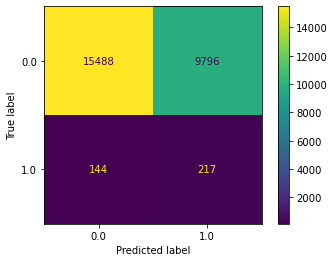

In [489]:
# Creating Confusion Matrix
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
# The below confusion matrix shows that 15,488 donors are True Positive (the donors are actually donating and model perdicts
# the same), 9,796 donors are False Positive (Type1 Error), 144 donors are False Negative (Type2 Error) and 217 donors are
# True Negative

from sklearn.metrics import ConfusionMatrixDisplay
cm_num = confusion_matrix(Y_test_num,logistic.predict(X_test_num))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_num,
                              display_labels=logistic.classes_)
disp.plot()
plt.show()

#### 3.4 ROC curve and AUC score for selected models

AUC Score for decision_tree 0.52
AUC Score for logistic 0.64
AUC Score for random_forest 0.62
AUC Score for Ada_boost 0.66
AUC Score for knn 0.54
AUC Score for gaussian 0.59
AUC Score for Neural_Network 0.5


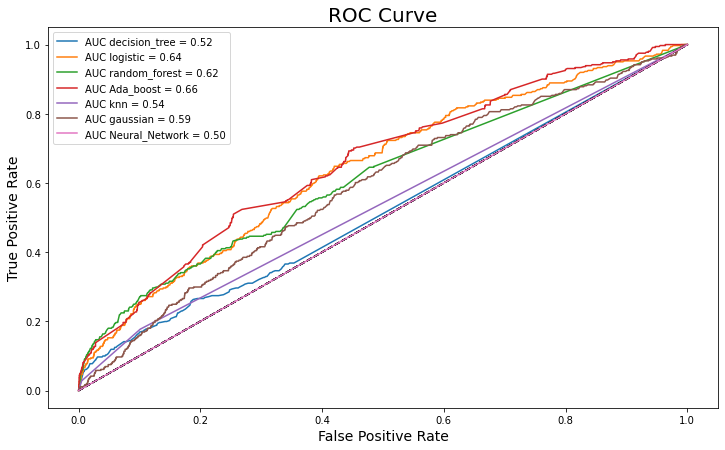

In [490]:
# Calculate and plot ROC curve and AUC Score
# Reference : https://towardsdatascience.com/roc-and-auc-how-to-evaluate-machine-learning-models-in-no-time-fb2304c83a7f

plt.figure(figsize=(12, 7))
for model in models:
    x =  models[model].predict_proba(X_test_num)[:, 1]
    y = roc_auc_score(Y_test_num, x)
    fpr, tpr, thresholds = roc_curve(Y_test_num, x)
    print('AUC Score for', model, round(y,2)) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'AUC {model} = {y:.2f}')
    plt.title('ROC Curve', size=20)
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend()

### 3.5 With Feature Selection

### 3.5 a. Univariate Selection

#### 1. Pearson Correlation

* For each variable, calculating the pearson correlation between the variable and target donated, and the corresponding p-value
* Constructing a model on train data that has only those variables that have a p-value lower than 0.001
* Calculating train and test AUC of this model

In [491]:
# Features
features = []
for column in donor_train.columns:
    if (column not in ("donorID","donated")) & (pd.api.types.is_numeric_dtype(donor_train[column])):
       features.append(column)

In [492]:
donor_train.head()

,donorID,dateOfBirth,gender_F,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,No_campaigns,Tot_Amt,Avg_Amt,Max_Amt,Min_Amt,recency,LOR,donated,Age,Age_group
0,100001,1967-12-24,1,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50,50
1,100002,1952-01-14,0,1,0,0,0,0,0,0,...,1.0,20.0,20.0,20.0,20.0,1302.0,1333.0,0.0,66,60
2,100004,1952-03-29,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66,60
3,100008,1937-08-30,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81,80
4,100009,1932-01-20,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86,80


In [493]:
# Calculate Pearson co-efficients for all features
selectedFeatures = []
select_features_log = []
target = "donated"

for column in donor_train.columns:
    if (column not in ("donorID","donated")) & (pd.api.types.is_numeric_dtype(donor_train[column])):
        (pearson,pvalue) = pearsonr(donor_train[column],donor_train[target])
        select_features_log.append(f"{column} - p-vlue = {pvalue} - selected : {1 if pvalue < 0.001 else 0}")
        if pvalue < 0.001:
            selectedFeatures.append(column)
selectedFeatures

['gender_F',
 'month',
 'max_gift',
 'min_gift',
 'sum_3',
 'No_campaigns',
 'Tot_Amt',
 'Avg_Amt',
 'Max_Amt',
 'Min_Amt',
 'recency',
 'LOR',
 'Age',
 'Age_group']

#### 2. SelectKBest 

In [494]:
# Reference : https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e
# Select best features

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(donor_train[features],donor_train['donated'])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(features)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
top_features_df = featureScores.nlargest(10,'Score')
top_features = list(top_features_df['Specs'])
print(top_features_df)  #print 10 best features

        Specs         Score
39        LOR  82605.833866
38    recency  38087.422203
41  Age_group   1853.962851
40        Age   1676.664988
19   max_gift   1316.590866
34    Tot_Amt   1221.045587
35    Avg_Amt   1221.045587
36    Max_Amt   1221.045587
37    Min_Amt   1221.045587
20   min_gift   1084.067185


<AxesSubplot:ylabel='Frequency'>

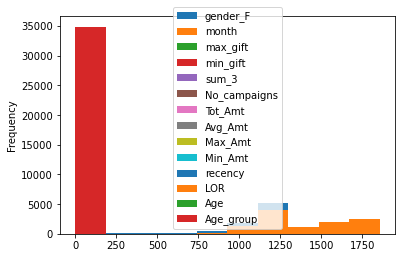

In [495]:
# Histogram of independent variable
donor_train[selectedFeatures].plot.hist()

<AxesSubplot:ylabel='Frequency'>

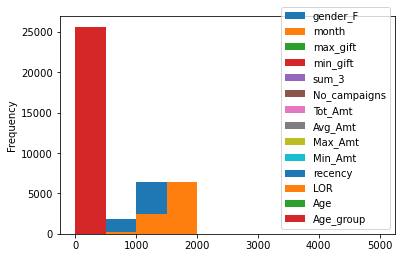

In [496]:
# Histogram of independent variable
donor_test[selectedFeatures].plot.hist()

#### 3.6 Initiate the Models

In [497]:
# Train and test data

X_train = donor_train[selectedFeatures]
Y_train = donor_train["donated"]
X_test  = donor_test[selectedFeatures]
Y_test  = donor_test['donated']
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((34874, 14), (34874,), (25645, 14), (25645,))

In [498]:
# Models
decision_tree = DecisionTreeClassifier().fit(X_train,Y_train)
logistic      = LogisticRegression(fit_intercept=True,solver='newton-cg',max_iter=500,class_weight='balanced').fit(X_train, Y_train)
random_forest = RandomForestClassifier(n_estimators=100).fit(X_train,Y_train)
ada_boost     = AdaBoostClassifier(n_estimators=100,learning_rate=1.1, random_state=40).fit(X_train,Y_train)
knn          = KNeighborsClassifier(n_neighbors = 5).fit(X_train,Y_train)
gaussian     = GaussianNB().fit(X_train,Y_train)
mlp           = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1).fit(X_train,Y_train)

In [499]:
# Create a dictionary of the models
models = {"decision_tree":decision_tree,
          "logistic"     :logistic,
          "random_forest":random_forest,
          "Ada_boost" : ada_boost,
          "knn" :knn,
          "gaussian"  :gaussian,
          "Neural_Network": mlp
         }

#### 3.7 Compute Accuracy and AUC for each Model

In [500]:
accuracy_scores = []

for model in models:
    pred_train = models[model].predict(X_train)
    pred_test = models[model].predict(X_test)
    acc_score_train = accuracy_score(Y_train, pred_train)
    acc_score_test = accuracy_score(Y_test,pred_test)
    a = [model,acc_score_train,acc_score_test]
    accuracy_scores.append(a)
    
accuracy_scores = pd.DataFrame(accuracy_scores)
accuracy_scores

,0,1,2
0,decision_tree,0.981304,0.978475
1,logistic,0.668406,0.620979
2,random_forest,0.981304,0.983545
3,Ada_boost,0.969691,0.985962
4,knn,0.967598,0.985494
5,gaussian,0.930607,0.942484
6,Neural_Network,0.966250,0.985923


In [501]:
len(donor_test[donor_test['donated'] == 1])

361

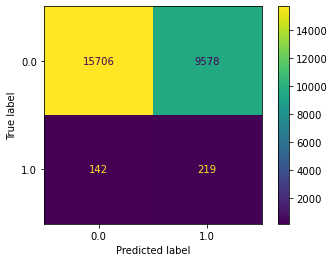

In [502]:
# Creating Confusion Matrix
# Reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html
# The below confusion matrix shows that 15,706 donors are True Positive (the donors are actually donating and model perdicts
# the same), 9,578 donors are False Positive (Type1 Error), 142 donors are False Negative (Type2 Error) and 219 donors are
# True Negative

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(Y_test,logistic.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=logistic.classes_)
disp.plot()
plt.show()

In [503]:
# Classification Report
# The precision tells us the accuracy of positive predictions.
# High recall: Predicted most True values correctly.
# The f1-score, or F measure, measures precision and recall at the same time by finding the harmonic mean of the two values.
# The accuracy measures the accuracy of all predictions (positive and negative).

print(classification_report(Y_test,logistic.predict(X_test)))

              precision    recall  f1-score   support

         0.0       0.99      0.62      0.76     25284
         1.0       0.02      0.61      0.04       361

    accuracy                           0.62     25645
   macro avg       0.51      0.61      0.40     25645
weighted avg       0.98      0.62      0.75     25645



#### 3.8 ROC curve and AUC score for selected models

AUC Score for decision_tree 0.51
AUC Score for logistic 0.64
AUC Score for random_forest 0.63
AUC Score for Ada_boost 0.66
AUC Score for knn 0.57
AUC Score for gaussian 0.6
AUC Score for Neural_Network 0.5


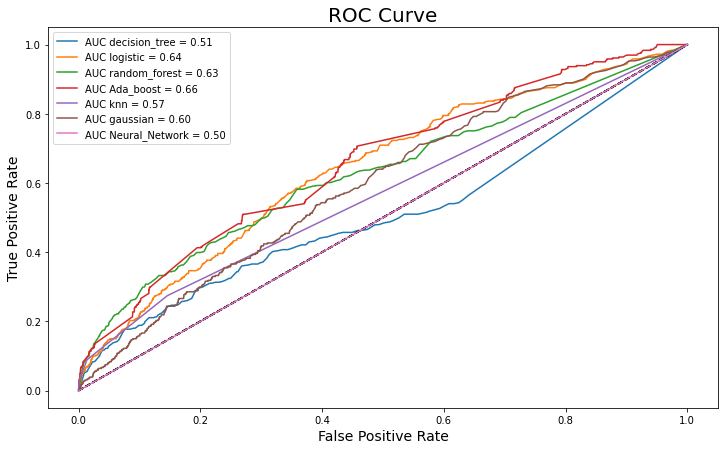

In [504]:
# Calculate and plot ROC curve and AUC Score
# Reference : https://towardsdatascience.com/roc-and-auc-how-to-evaluate-machine-learning-models-in-no-time-fb2304c83a7f
# Reference : https://gsarantitis.wordpress.com/2020/04/29/auc-roc-gains-chart-and-lift-curve-explained-with-business-implications/

plt.figure(figsize=(12, 7))
for model in models:
    x =  models[model].predict_proba(X_test)[:, 1]
    y = roc_auc_score(Y_test, x)
    fpr, tpr, thresholds = roc_curve(Y_test, x)
    print('AUC Score for', model, round(y,2)) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=f'AUC {model} = {y:.2f}')
    plt.title('ROC Curve', size=20)
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend()

### 4. Model Validation

In [505]:
# Calculate Lift, Gain and Response for all models
lifts     = {}
cumulative_responses = {}
cumulative_gains     = {}
data      = pd.DataFrame(Y_test).copy() #validation set with targeted variable
for (index,model) in enumerate(models):
    data[f"proba {model}"] = pd.DataFrame(models[model].predict_proba(X_test))[1] #predict proba for validation set features
    lifts[model] = lift(dataSet = data, actuals = "donated", probability = "proba "+str(model))
    cumulative_responses[model] = cumulativeResponse(dataSet = data, actuals = "donated", probability = "proba "+str(model))
    cumulative_gains[model] = cumulativeGains(dataSet = data, actuals = "donated", probability = "proba "+str(model))
    lifts[model]["Quantile"] = 1 - lifts[model]["Quantile"]
    cumulative_responses[model]["Quantile"] = 1 - cumulative_responses[model]["Quantile"]
    cumulative_gains[model]["Quantile"] = 1 - cumulative_gains[model]["Quantile"]

In [506]:
data.head()

,donated,proba decision_tree,proba logistic,proba random_forest,proba Ada_boost,proba knn,proba gaussian,proba Neural_Network
0,0.0,0.040909,0.553061,0.040462,0.492760,0.0,0.020118,0.033749
1,0.0,0.000000,0.575222,0.000000,0.489897,0.0,0.201058,0.033749
2,0.0,0.037736,0.497576,0.036179,0.491712,0.2,0.079169,0.033749
3,0.0,0.032258,0.555268,0.027381,0.493160,0.0,0.109171,0.033749
4,0.0,0.000000,0.342116,0.000000,0.485370,0.0,0.026198,0.033749


In [507]:
cumulative_responses["logistic"].head()

,Quantile,Cumulative response,Average response
19,0.00,0.041309,0.014077
18,0.05,0.029607,0.014077
17,0.10,0.028520,0.014077
16,0.15,0.024752,0.014077
15,0.20,0.023550,0.014077


#### 4.1 Plot Lifts

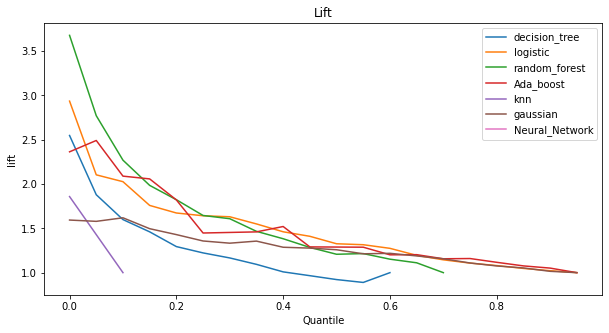

In [508]:
# Plot Lift for all Models

plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(lifts[model]["Quantile"], lifts[model]["Lift"], label = model)
    plt.xlabel("Quantile")
    plt.ylabel("lift")
    plt.title("Lift")
    plt.legend()

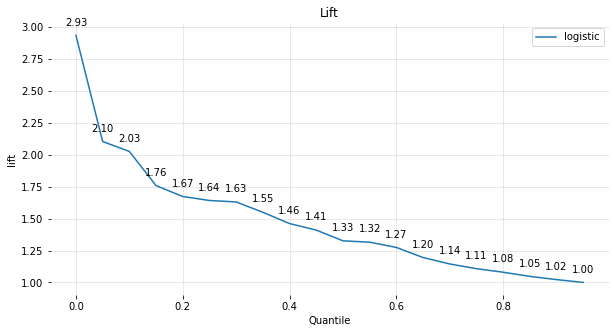

In [509]:
# plotting lifts for logistic
# Reference : https://stackoverflow.com/questions/58722650/plot-only-class-1-vs-baseline-in-lift-curve-and-cumulative-gains-chart-in-scikit

fig, ax = plt.subplots(figsize=(10, 5))
x_log = lifts['logistic']["Quantile"]
y_log = lifts['logistic']["Lift"]
plt.plot(x_log,y_log , label = 'logistic')
plt.xlabel("Quantile")
plt.ylabel("lift")
plt.title("Lift")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, alpha = 0.5)
for x,y in zip(x_log,y_log):
        label = "{:.2f}".format(y)
        plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.legend()

#### 4.2 Plot Cumulative Response

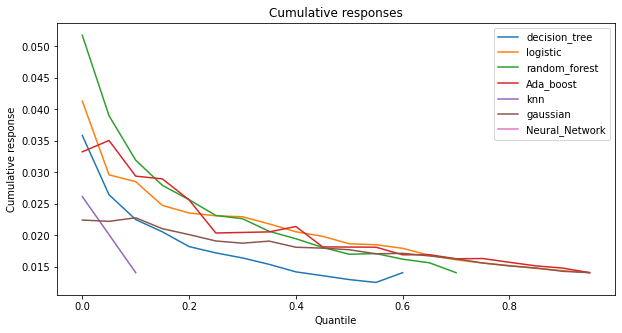

In [510]:
# Plot Cumulative Response for all Models
plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(cumulative_responses[model]["Quantile"], cumulative_responses[model]["Cumulative response"],
            label = model)
    plt.xlabel("Quantile")
    plt.ylabel("Cumulative response")
    plt.title("Cumulative responses")
    plt.legend()

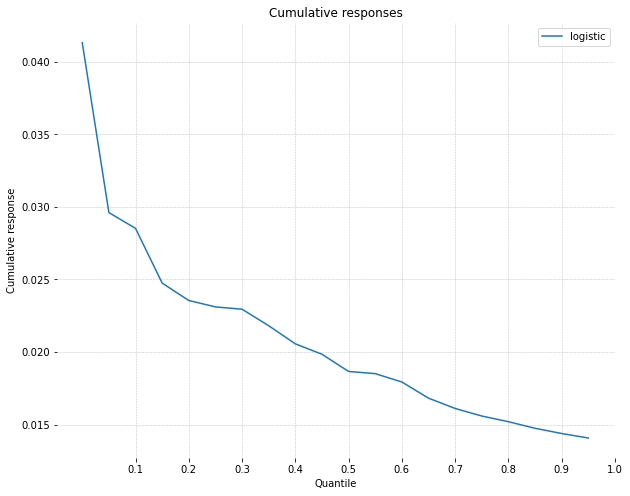

In [511]:
# Plotting cumulative responses for logistic

fig, ax = plt.subplots(figsize=(10, 8))
plt.plot(cumulative_responses["logistic"]["Quantile"], cumulative_responses["logistic"]["Cumulative response"],
            label = "logistic")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks(ticks=np.arange(0.1,1.1,0.1))
plt.xlabel("Quantile")
plt.ylabel("Cumulative response")
plt.title("Cumulative responses")
plt.legend()

#### 4.3 Plot Cumulative Gains

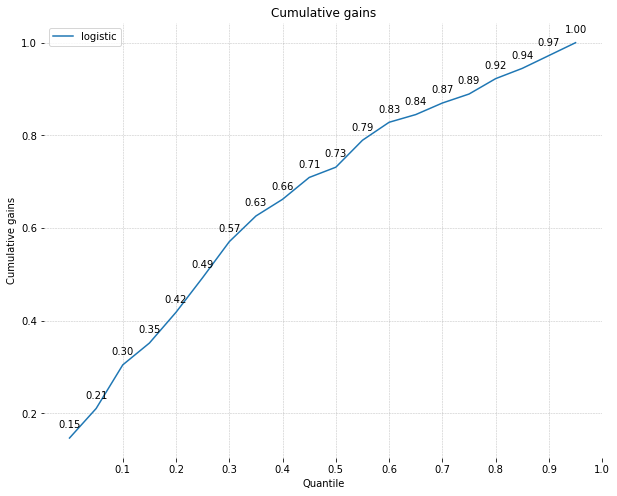

In [512]:
# Plotting cumulative gains for logistic

fig, ax = plt.subplots(figsize=(10, 8))
x_ga = cumulative_gains["logistic"]["Quantile"]
y_ga = cumulative_gains["logistic"]["Cumulative gains"]
plt.plot(x_ga, y_ga, label = "logistic")
plt.xlabel("Quantile")
plt.ylabel("Cumulative gains")
plt.title("Cumulative gains")
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, alpha = 0.5)
ax.set_xticks(ticks=np.arange(0.1,1.1,0.1))
for x,y in zip(x_ga,y_ga):
        label = "{:.2f}".format(y)
        plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                ha='center') # horizontal alignment can be left, right or center      
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)        
plt.legend()

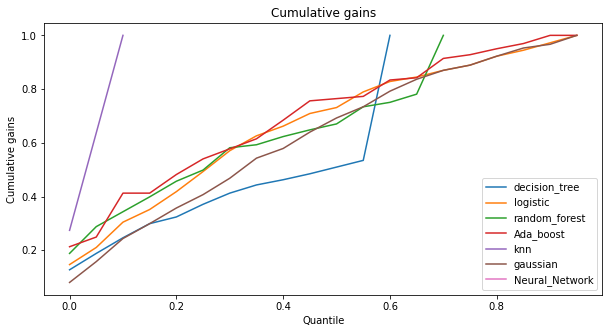

In [513]:
# Plotting Cumulative Gains for all Models
plt.figure(figsize=(10, 5))
for model in models:
    plt.plot(cumulative_gains[model]["Quantile"], cumulative_gains[model]["Cumulative gains"], label = model)
    plt.xlabel("Quantile")
    plt.ylabel("Cumulative gains")
    plt.title("Cumulative gains")
    plt.legend()

In [514]:
donor_new['donated'].describe()

count    26511.000000
mean         0.013504
std          0.115421
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: donated, dtype: float64

### 5. Model Usage

In [515]:
# Calculating the probability and target for scoring dataset

donor_score = donor_new.copy()
donor_score['probability'] = pd.DataFrame(logistic.predict_proba(donor_score[selectedFeatures]))[1]
donor_score['donated'] = pd.DataFrame(logistic.predict(donor_score[selectedFeatures]))
donor_score

,donorID,dateOfBirth,gender_F,province_Antwerp,province_Brussels,province_East Flanders,province_Flemish Brabant,province_Hainaut,province_Liege,province_Limburg,...,Tot_Amt,Avg_Amt,Max_Amt,Min_Amt,recency,LOR,donated,Age,Age_group,probability
0,100001,1967-12-24,1,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,52,50,0.562585
1,100003,1986-12-23,0,0,0,0,1,0,0,0,...,5.0,5.0,5.0,5.0,27.0,922.0,1.0,33,30,0.582966
2,100004,1952-03-29,1,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,67,60,0.675964
3,100006,1926-06-01,0,0,1,0,0,0,0,0,...,5.0,5.0,5.0,5.0,354.0,903.0,1.0,93,90,0.842289
4,100009,1932-01-20,0,0,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,88,80,0.564782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26506,144687,1970-09-12,0,0,0,0,0,0,1,0,...,10.0,10.0,10.0,10.0,1002.0,1551.0,0.0,49,40,0.493406
26507,144688,1972-11-28,0,0,0,0,0,0,0,1,...,15.0,15.0,15.0,15.0,373.0,922.0,1.0,47,40,0.588017
26508,144689,1967-04-21,0,0,0,0,1,0,0,0,...,100.0,100.0,100.0,100.0,40.0,589.0,0.0,52,50,0.429854
26509,144690,1976-05-07,0,0,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43,40,0.250728


In [516]:
# Cumulative Responses for the selected model 

cumulative_responses["logistic"]

,Quantile,Cumulative response,Average response
19,0.00,0.041309,0.014077
18,0.05,0.029607,0.014077
17,0.10,0.028520,0.014077
16,0.15,0.024752,0.014077
15,0.20,0.023550,0.014077
14,0.25,0.023111,0.014077
13,0.30,0.022950,0.014077
12,0.35,0.021813,0.014077
11,0.40,0.020566,0.014077
10,0.45,0.019848,0.014077


In [517]:
# Write probabilities to file
donor_score[['donorID','donated','probability']].to_csv('Group4_scoring.csv')

### 6. Profiling

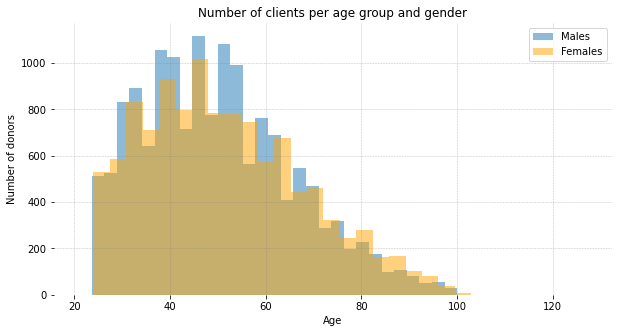

In [406]:
# Number of clients per age group and gender

fig, ax = plt.subplots(figsize = (10,5))
ax.hist(donor_score.loc[donor_score['gender_F'] == 0, 'Age'], bins=30, alpha=0.5, label='Males')
ax.hist(donor_score.loc[donor_score['gender_F'] == 1, 'Age'], bins=30, alpha=0.5, label='Females', color = 'orange')
ax.set_title('Number of clients per age group and gender')
ax.set_xlabel('Age')
ax.set_ylabel('Number of donors')
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5, alpha = 0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.legend()
plt.show()